# 1 - Multi-armed bandits (3 pts.)
In this part of the homework, you will reproduce some of the results in Chapter 2 of the Sutton and Barto
book.

Suppose that you have a 10-armed bandit problem—i.e., an agent has to select among a set of 10
different actions, each of which yields a different (average) reward. In particular, suppose that the actual
reward associated with each action a ∈ {1, . . . , 10} is a random variable following a Gaussian distribution
with mean Q(a) and variance 1.  
You will compare the average reward received by:  
>• A greedy policy, where the estimated reward for each action a is initialized as Qˆ(a) = 0;  
    • A greedy policy, where the estimated reward for each action a is initialized as Qˆ(a) = 5;  
    • An ε-greedy policy, with ε = 0.1, where the estimated reward for each action a is initialized as Qˆ(a) = 0;  
    • An ε-greedy policy, with ε = 0.01, where the estimated reward for each action a is initialized as Qˆ(a) = 0;  
    • The UCB policy. 

To do this

1. Select the average values Q(a), a ∈ {1, . . . , 10} , at random from a normal distribution with mean 0 and variance 1;
2. Run the policies listed above for 1, 000 steps and compute, for each policy, the reward received at each time step;
3. Repeat the two previous steps 2, 000 times;
4. Compute the reward obtained at each time step by each of the policies averaged across the 2, 000 trials.

**Question 1. Using the results from the procedure outlined above, plot the average reward obtained with each policy during the 1, 000 steps in a single plot. Comment the differences observed.**

### Notes

A greedy policy is an ε-greedy policy with ε = 0;  
NumPy provides a normal distribution: https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html;

Q(a) at timestep t is calculated by:  

![image info](./pictures/qa.png)


![image.info](./pictures/bandit.png)


Previous images are from the *Reinforcement Learning: An Introduction* book, by Sutton and Barto, found in:  
http://incompleteideas.net/sutton/book/the-book-2nd.html

In [34]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [95]:
# Attempt a simple bandit

class Bandit(object):
    
    # Variable initialization
    def __init__(self, n_actions=10, iterations=1000, use_ucb=True, initial_qa=0.0, epsilon=0.0, c=0.0):
        # Set the size of action space
        self.n_actions = n_actions
        
        # Initial Q(a) values
        self.q_actions = np.array([initial_qa for i in np.arange(self.n_actions)])
        
        # Value of picking an action
        self.rewards = np.zeros(self.n_actions)
        
        # Times chosen each action
        self.times_chosen = np.zeros(self.n_actions)
        
        # Number of iteration
        self.max_iterations = iterations
        
        # Number of timesteps
        self.timestep = 0
        
        # Whether we used or not the UCB
        self.is_UCB = use_ucb
        
        # Epsilon for greedy - greedy is 1-
        self.epsilon = epsilon
        
        # Constant C value for UCB
        self.c_value = c
        
        # Total reward
        self.total_reward = 0.0
        
        # Records
        self.records = None
        
    # Return an array of 10 values sampled from a normal distribution
    def __generate_normal__(self, mean=0.0, variance=1.0):
        return np.random.normal(mean, variance, self.n_actions)
    
    # Get Q(a) at timestep n+1
    def __update_action_value__(self, current_q, current_r, times_chosen):
        next_qa = current_q + (current_r - current_q) * (times_chosen ** -1)
        return next_qa
        
    
    # Pick action A at t+1
    def __select_action_ucb__(self):
        next_action = np.argmax([self.q_actions[i] + self.c_value * np.sqrt(np.log(self.timestep) * (self.times_chosen[i]**-1)) 
                                 for i in np.arange(self.n_actions)])
        
        return next_action
    
    def __select_action_epsilon__(self):
        if epsilon <= np.random.random():
            known_action = np.argmax(self.q_actions)
            
            # Generate probs for each action
            prob_actions = __generate_normal__()
            prob_actions[known_action] = -999
            return np.argmax(prob_actions)
        else:
            return np.argmax(self.q_actions)
        
    def __generate_records__(self):
        new_df = pd.DataFrame({'Cumulative Reward': self.total_reward}, index=[self.timestep])
        for action in np.arange(self.n_actions):
            new_df['N(A{})'.format(action)] = self.times_chosen[action]
            new_df['R(A{})'.format(action)] = self.rewards[action]
        
        return new_df
        
            
    def iterate(self):
        # 1 - Initialize Q(a) -> done on class initialization
        # 2 - Generate next rewards from normal distribution
        # 3 - If is UBC, pick each action exactly once first
        # 4 - Pick action based on the UCB or greedy
        # 5 - Get reward for action selected
        # 6 - Update counter of selection for action selected
        # 7 - Get new Q(a) for the selected action
        
        df = pd.DataFrame({})
        
        if self.is_UCB:
            # Pick each action once
            for action in np.arange(self.n_actions):
                self.rewards = self.__generate_normal__()
                self.times_chosen[action] += 1
                self.timestep += 1
                self.__update_action_value__(current_q=self.q_actions[action],
                                             current_r=self.rewards[action],
                                             times_chosen=self.times_chosen[action])
                self.total_reward += self.rewards[action]
                current_record = self.__generate_records__()
                df = df.append(current_record)
        
        for iteration in np.arange(self.max_iterations):
            # Get the rewards for each action
            self.rewards = self.__generate_normal__()

            # Pick action
            picked_action = 0
            if self.is_UCB:
                picked_action = self.__select_action_ucb__()
            else:
                picked_action = self.__select_action_epsilon__()

            # Update timestep and action counter
            self.times_chosen[picked_action] += 1
            self.timestep += 1

            # Update Q(a)
            self.__update_action_value__(current_q=self.q_actions[picked_action], 
                                         current_r=self.rewards[picked_action], 
                                         times_chosen=self.times_chosen[picked_action])
            
            self.total_reward += self.rewards[picked_action]
            
            current_record = self.__generate_records__()
            df = df.append(current_record)
        
        self.records = df
        
        return self.records

In [96]:
# Instantiate the Bandit class for UCB with C=0 (for test)

bandit = Bandit(iterations=20, use_ucb=True)
bandit.iterate()

,Cumulative Reward,N(A0),R(A0),N(A1),R(A1),N(A2),R(A2),N(A3),R(A3),N(A4),...,N(A5),R(A5),N(A6),R(A6),N(A7),R(A7),N(A8),R(A8),N(A9),R(A9)
1,-0.630235,1.0,-0.630235,0.0,0.786861,0.0,-1.395742,0.0,-0.161710,0.0,...,0.0,1.537220,0.0,0.993195,0.0,-1.814336,0.0,0.546086,0.0,0.623271
2,-0.105120,1.0,0.626426,1.0,0.525115,0.0,-0.069551,0.0,0.797284,0.0,...,0.0,-0.717310,0.0,1.319244,0.0,1.925690,0.0,-0.313372,0.0,-0.399113
3,-0.936725,1.0,-0.055613,1.0,-1.739242,1.0,-0.831605,0.0,-0.105038,0.0,...,0.0,0.590888,0.0,-1.219512,0.0,-0.803838,0.0,-1.345762,0.0,-0.436403
4,-1.590544,1.0,-1.350186,1.0,-1.069026,1.0,-1.863579,1.0,-0.653819,0.0,...,0.0,1.718826,0.0,-0.483410,0.0,0.670235,0.0,-1.427471,0.0,-0.621238
5,-2.647427,1.0,0.380076,1.0,0.372919,1.0,-0.502704,1.0,-0.249353,1.0,...,0.0,0.595018,0.0,1.042978,0.0,-2.419998,0.0,0.001642,0.0,-0.651803
6,-1.935092,1.0,-0.754327,1.0,0.106351,1.0,-1.001502,1.0,1.115258,1.0,...,1.0,0.712335,0.0,0.154342,0.0,0.739532,0.0,-1.384962,0.0,0.135399
7,-0.233011,1.0,0.017170,1.0,0.588314,1.0,-0.037414,1.0,0.837065,1.0,...,1.0,0.554182,1.0,1.702081,0.0,0.110497,0.0,0.356973,0.0,-0.869573
8,0.984037,1.0,-1.972300,1.0,1.099058,1.0,1.428585,1.0,0.420326,1.0,...,1.0,0.137128,1.0,-0.033747,1.0,1.217048,0.0,0.461265,0.0,0.810448
9,1.608192,1.0,1.168250,1.0,1.031067,1.0,2.351116,1.0,-1.450035,1.0,...,1.0,-0.228981,1.0,-0.220252,1.0,0.196345,1.0,0.624155,0.0,1.594852
10,0.887894,1.0,-0.271747,1.0,-0.722946,1.0,1.244640,1.0,-1.623458,1.0,...,1.0,0.403369,1.0,-0.228341,1.0,0.523334,1.0,0.546628,1.0,-0.720299


Text(0, 0.5, 'Cumulative Reward')

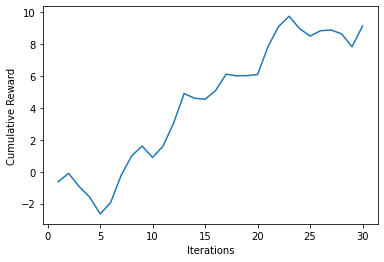

In [98]:
# Plot the Cumulative Reward

plt.plot(bandit.records['Cumulative Reward'])
plt.xlabel('Iterations')
plt.ylabel('Cumulative Reward')